# Libraries

In [116]:
import torch
import torch.nn as nn
from models.pointnet2_utils import PointNetSetAbstraction
from tqdm import tqdm
import torch.nn.functional as F
import open3d as o3d
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import random
import munkres
import os
import sys
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pprint
sys.path.append(os.path.abspath('/home2/ansh.shah/FinderNet/'))
from Findernet_Data_Assoc.Codebase.util.o3d_util import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Utility Functions

In [117]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [118]:
def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    
def plot_open3d_pointcloud(open3d_pcd):
        # Extract the point cloud data
        points = np.asarray(open3d_pcd.points)

        # Separate the points into X, Y, and Z coordinates
        xs = points[:, 0]
        ys = points[:, 1]
        zs = points[:, 2]

        # Create a 3D scatter plot using Plotly
        trace = go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')

        # Define the layout and create the figure
        layout = go.Layout(scene=dict(aspectmode="data"))
        fig = go.Figure(data=[trace], layout=layout)

        # Show the Plotly figure
        fig.show()

# function to sample farthest points by randomly picking points
def farthest_point_sample(point, npoint):
    """
    Input:
        xyz: pointcloud data, [N, D]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [npoint, D]
    """
    N, D = point.shape
    xyz = point[:,:3]
    centroids = np.zeros((npoint,))
    distance = np.ones((N,)) * 1e10
    farthest = np.random.randint(0, N)
    for i in range(npoint):
        centroids[i] = farthest
        centroid = xyz[farthest, :]
        dist = np.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = np.argmax(distance, -1)
    point = point[centroids.astype(np.int32)]
    return point

In [119]:
def create_masks(sem_image):
    # Flatten the RGB image to a 2D array for finding unique colors
    flattened_image = sem_image.reshape(-1, 3)
    
    # Get the unique combinations of RGB values
    unique_colors = np.unique(flattened_image, axis=0)

    masks = {}
    mask_colors = []

    for color in unique_colors:
        # Create a mask by comparing the entire RGB array with the unique color
        mask = np.all(sem_image == color, axis=2)
        masks[tuple(color)] = mask
        mask_colors.append(tuple(color))
    
    return masks, mask_colors

In [120]:
# code for sampling points from a mesh
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

# Model

In [121]:
class get_model(nn.Module):
    def __init__(self, num_class, normal_channel=True):
        super(get_model, self).__init__()
        in_channel = 6 if normal_channel else 3
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstraction(
            npoint=512,
            radius=0.2,
            nsample=32,
            in_channel=in_channel,
            mlp=[64, 64, 128],
            group_all=False,
        )
        self.sa2 = PointNetSetAbstraction(
            npoint=128,
            radius=0.4,
            nsample=64,
            in_channel=128 + 3,
            mlp=[128, 128, 256],
            group_all=False,
        )
        self.sa3 = PointNetSetAbstraction(
            npoint=None,
            radius=None,
            nsample=None,
            in_channel=256 + 3,
            mlp=[256, 512, 1024],
            group_all=True,
        )
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)

        return x, l3_points

In [122]:
# load state dict
checkpoint = torch.load(
    "log/classification/pointnet2_ssg_wo_normals/checkpoints/best_model.pth",
    map_location=torch.device("cpu"),
)

# load model
print(checkpoint.keys())

dict_keys(['epoch', 'instance_acc', 'class_acc', 'model_state_dict', 'optimizer_state_dict'])


In [123]:
model = get_model(40, normal_channel=False)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [124]:
model.to(device)

get_model(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(131, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNetSetAbstract

In [125]:
pcd = o3d.io.read_point_cloud("/scratch/ansh/object pcds/gt_object_83.pcd")
print(pcd)
plot_open3d_pointcloud(pcd)

PointCloud with 6391 points.


In [126]:
resampled_pcd = o3d.geometry.PointCloud()
resampled_np = np.array(farthest_point_sample(np.array(pcd.points), 2000))
# add noise to array
noise = np.random.normal(0, 0.01, resampled_np.shape)
resampled_np += noise
resmaple_np = resampled_np/(np.max(resampled_np)-np.min(resampled_np))
resampled_pcd.points = o3d.utility.Vector3dVector(resampled_np)
plot_open3d_pointcloud(resampled_pcd)

In [127]:
pcd_resampled_torch = torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)
print(pcd_resampled_torch.shape)
pcd_resampled_torch_input = (pcd_resampled_torch.expand(1, -1, 3).permute(0, 2, 1))
print(pcd_resampled_torch_input.shape)

torch.Size([6391, 3])
torch.Size([1, 3, 6391])


In [128]:
pcd_torch = torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)
print(pcd_torch.shape)
pcd_torch_input = (pcd_torch.expand(1, -1, 3).permute(0, 2, 1))
print(pcd_torch_input.shape)

torch.Size([6391, 3])
torch.Size([1, 3, 6391])


In [129]:
model.eval()

pcd_torch_output = model(pcd_torch_input)
pcd_resampled_torch_output = model(pcd_resampled_torch_input)

In [130]:
# verts, faces = read_off(file=open("/media/baymax/Elements/RRC/ShapeNet/Unzipped/modelnet40/ModelNet40/airplane/test/airplane_0627.off", mode="r"))
# print(verts)
# i,j,k = np.array(faces).T
# x,y,z = np.array(verts).T
# len(x)

In [131]:
# now i want to visualize the point cloud from off file
# pcshow(x,y,z)

In [132]:
# pointcloud = PointSampler(3000)((verts, faces))
# pcshow(*pointcloud.T)

In [133]:
# # loading the point cloud from the off file to tensor to passs through the model
# a = np.asarray(pointcloud)
# a = torch.tensor(a, dtype=torch.float32).to(device)
# a = a/10
# print(a)
# x = (a.expand(1, -1, 3).permute(0, 2, 1))
# # print(x.shape)
# print(model(x)[0].argmax(dim=1))

In [134]:
# pcd_resampled_torch_output[1].squeeze(0).shape
F.cosine_similarity(pcd_torch_output[1].squeeze(0), pcd_resampled_torch_output[1].squeeze(0), dim=0)

tensor([0.9993], device='cuda:0', grad_fn=<SumBackward1>)

In [135]:
point_net_emb = []

# Specify the directory path
dir_path = '/scratch/ansh/Data_Assoc/Dataset/360_multiple'

# Create a dictionary to store orientation folders, views, and their files
orientation_views_files = {}

# Get a list of all items in the directory
all_items = os.listdir(dir_path)

# Filter the items to get only folders that start with "orientation"
orientation_folders = [item for item in all_items if os.path.isdir(os.path.join(dir_path, item)) and item.startswith("orientation")]

# Loop through the orientation folders
for orientation_folder in tqdm(sorted(orientation_folders)):
    orientation_folder_path = os.path.join(dir_path, orientation_folder)
    
    # Get a list of all items (views) within the orientation folder
    views = [view for view in os.listdir(orientation_folder_path) if (os.path.isdir(os.path.join(orientation_folder_path, view)) and view.startswith("view"))]
    # Create a dictionary to store files for each view
    view_files = {}
    # Loop through the view folders
    for view in sorted(views):
        view_folder_path = os.path.join(orientation_folder_path, view)
        
        # Get a list of files in the view folder (e.g., rgb img, depth.npy, sem_img)
        files = os.listdir(view_folder_path)
        
        # Add the list of files to the view_files dictionary
        view_files[view] = files

        # create masks and save them in view folder with imgs under the name of color_mask : color_mask_0: mask later save truncated depth, color_mask_1, color_mask_2, color_mask_3
        masks, mask_colors = create_masks(np.array(Image.open(os.path.join(view_folder_path, '{view}_sem.png'.format(view=view)))))
        masks_store = {}
        # print(masks)
        # for mask in masks:
        #     Image_depth_mask(np.load(os.path.join(view_folder_path, '{view}.npy'.format(view=view))), masks[mask])
        #     masks_store['masked_pcd_{mask}']
        for color, mask in masks.items():
            depth_mask = Image_depth_mask(np.load(os.path.join(view_folder_path, f'{view}.npy')), mask)
            
            pcd = Image_depth_to_pointcloud(rgb_image=np.array(Image.open(os.path.join(view_folder_path, '{view}.png'.format(view=view)))), depth_image=depth_mask,cx=300,cy=300,fx=300,fy=300)
            masks_store[color] = depth_mask,  np.array(pcd.points)
        view_files[view].append(masks_store)
        break
    # Add the orientation folder, views, and their files to the main dictionary
    orientation_views_files[orientation_folder] = view_files
print(orientation_views_files)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# save orientation_views_files create new file
with open('/scratch/ansh/Data_Assoc/Dataset/360_multiple/orient_views_files.pkl', 'wb') as f:
    pickle.dump(orientation_views_files, f)

In [136]:
# load orientation_views_files
with open('/scratch/ansh/Data_Assoc/Dataset/360_multiple/orient_views_files.pkl', 'rb') as f:
    orientation_views_files = pickle.load(f)

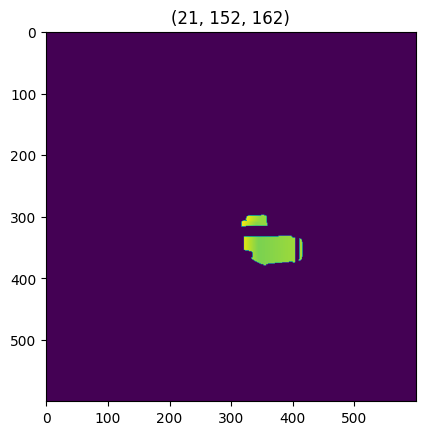

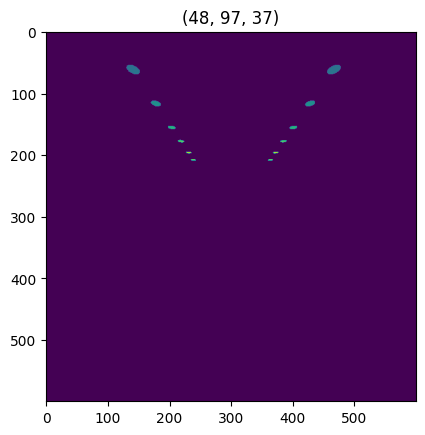

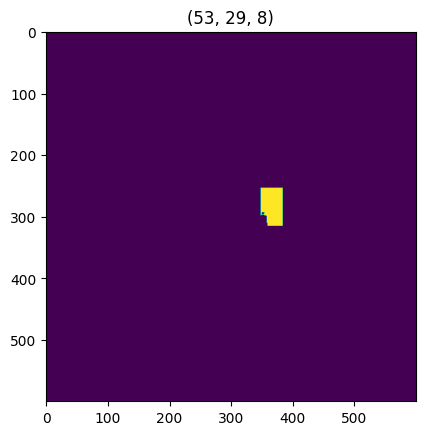

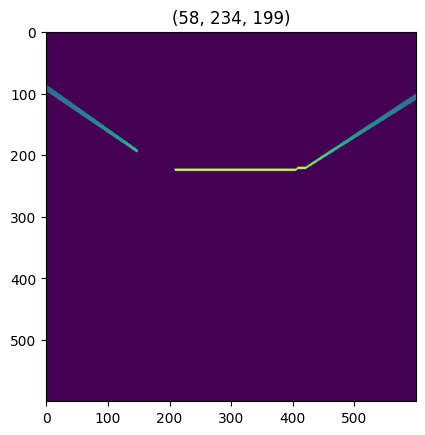

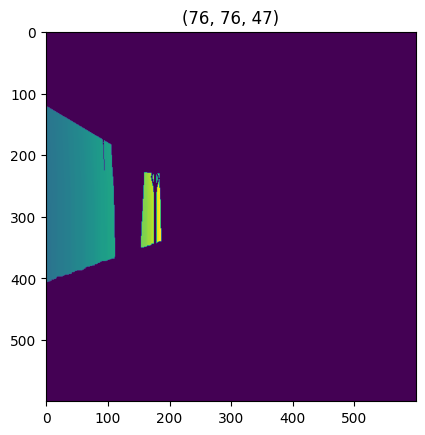

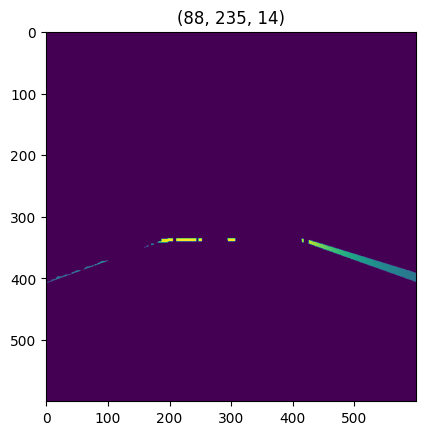

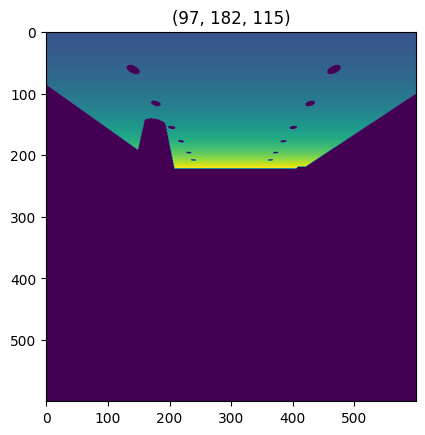

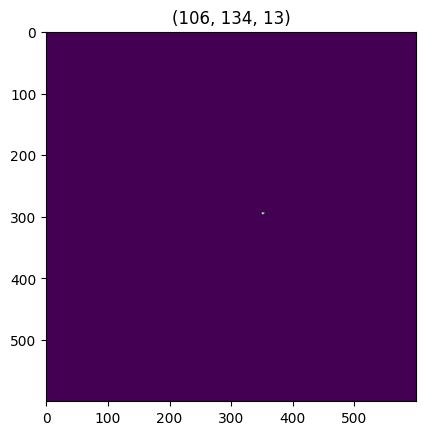

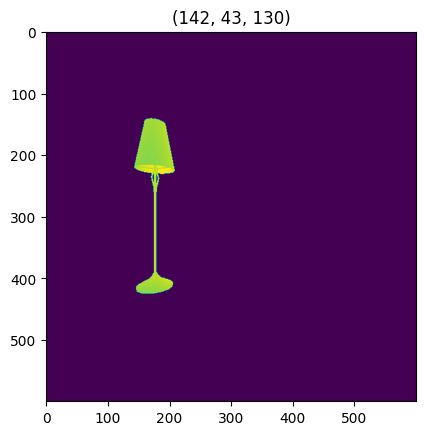

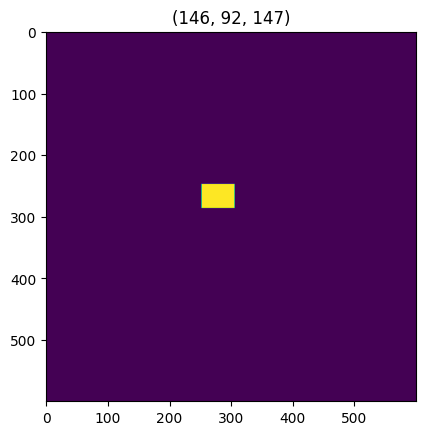

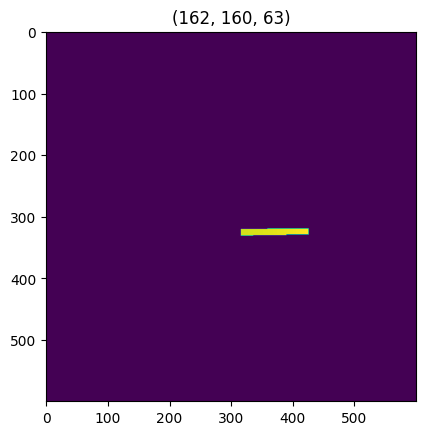

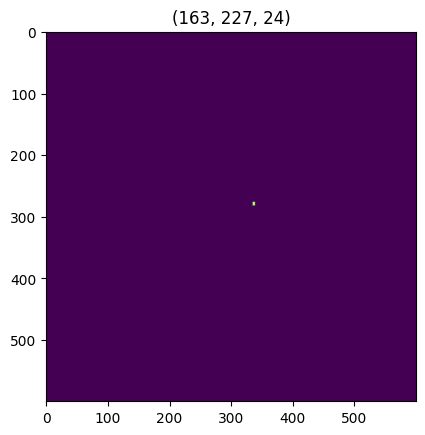

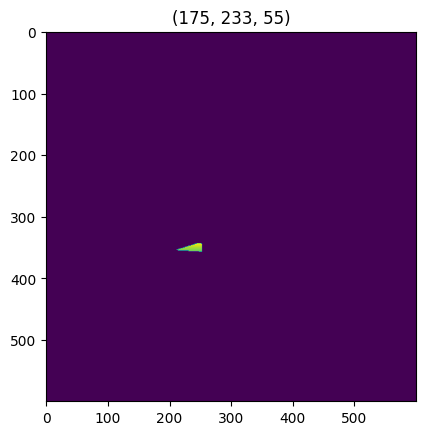

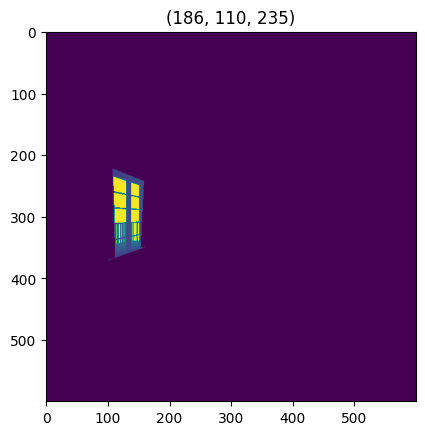

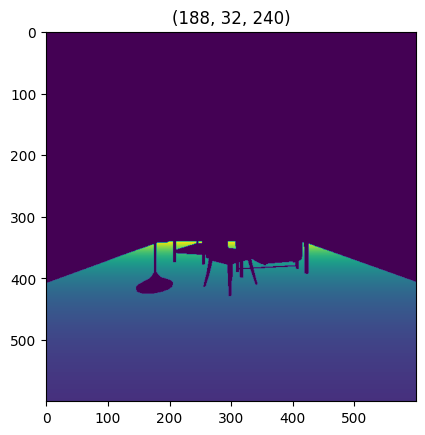

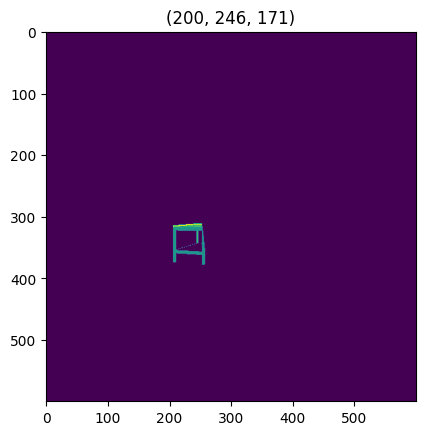

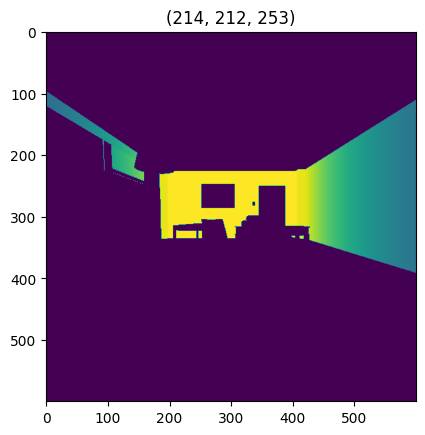

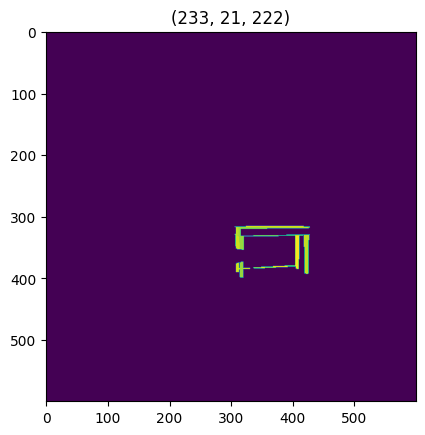

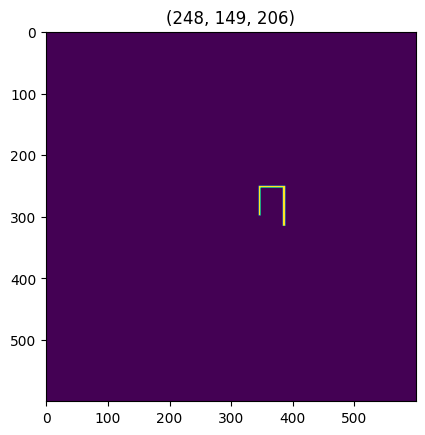

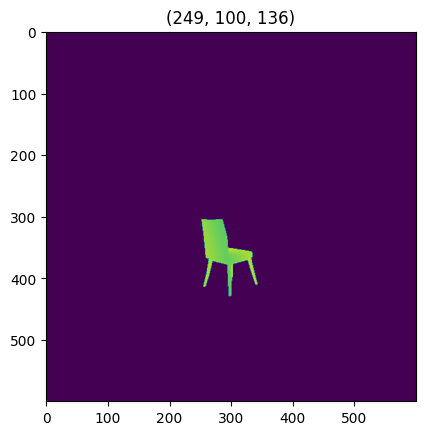

In [156]:
for color in orientation_views_files['orientation1']['view1'][4]:
    pcd = orientation_views_files['orientation1']['view1'][4][color]
    plt.title(color)
    plt.imshow(pcd[0])
    plt.show()
    # resampled_pcd = o3d.geometry.PointCloud()
    # resampled_np = np.array(farthest_point_sample(np.array(pcd[1]), 2000))
    # resampled_np = np.array(pcd[1])
    # resampled_pcd.points = o3d.utility.Vector3dVector(resampled_np)
    # noise = np.random.normal(0, 0.01, resampled_np.shape)
    # resampled_np += noise
    # plot_open3d_pointcloud(resampled_pcd)
    # resampled_np = np.array(farthest_point_sample(np.array(pcd.points), 2000))
    # # add noise to array

    # resmaple_np = resampled_np/(np.max(resampled_np)-np.min(resampled_np))
    # plot_open3d_pointcloud(resampled_pcd)

In [138]:
point_net_emb = []
successful_model = []
for orientation in tqdm(orientation_views_files):
    for i, view in enumerate(orientation_views_files[orientation]):
        for color in orientation_views_files[orientation][view][4]:
            pcd = orientation_views_files[orientation][view][4][color]
            a,b = pcd[1].shape
            if a < 1024:
                continue
            if a > 1024:
                pcd_resampled = farthest_point_sample(pcd[1], 1024)
            
            pcd_resampled = Normalize()(pcd_resampled)

            a = torch.tensor(pcd_resampled, dtype=torch.float32).to(device)
            x = (a.expand(1, -1, 3).permute(0, 2, 1))
            # # print(x.shape)
            try:
                output = model(x)
                print(output[0].argmax(dim=1))
                point_net_emb.append(output[1].squeeze(0).detach().cpu())
                successful_model.append((orientation, view, color))
                del a
            except Exception as e:
                print("error{color}")
                del a
                continue

  0%|          | 0/8 [00:00<?, ?it/s]

tensor([19], device='cuda:0')
tensor([26], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([11], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([20], device='cuda:0')


 12%|█▎        | 1/8 [00:11<01:23, 11.86s/it]

tensor([26], device='cuda:0')
tensor([25], device='cuda:0')
tensor([26], device='cuda:0')
tensor([20], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([11], device='cuda:0')
tensor([22], device='cuda:0')


 25%|██▌       | 2/8 [00:23<01:10, 11.74s/it]

tensor([31], device='cuda:0')
tensor([3], device='cuda:0')
tensor([26], device='cuda:0')
tensor([20], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([14], device='cuda:0')


 38%|███▊      | 3/8 [00:35<00:58, 11.67s/it]

tensor([26], device='cuda:0')
tensor([31], device='cuda:0')
tensor([26], device='cuda:0')
tensor([20], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([3], device='cuda:0')
tensor([11], device='cuda:0')


 50%|█████     | 4/8 [00:46<00:46, 11.64s/it]

tensor([26], device='cuda:0')
tensor([20], device='cuda:0')
tensor([26], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([20], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([22], device='cuda:0')


 62%|██████▎   | 5/8 [00:58<00:35, 11.69s/it]

tensor([26], device='cuda:0')
tensor([3], device='cuda:0')
tensor([26], device='cuda:0')
tensor([18], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')


 75%|███████▌  | 6/8 [01:10<00:23, 11.65s/it]

tensor([31], device='cuda:0')
tensor([17], device='cuda:0')
tensor([26], device='cuda:0')
tensor([18], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([34], device='cuda:0')


 88%|████████▊ | 7/8 [01:21<00:11, 11.70s/it]

tensor([31], device='cuda:0')
tensor([6], device='cuda:0')
tensor([26], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')
tensor([17], device='cuda:0')
tensor([18], device='cuda:0')
tensor([19], device='cuda:0')
tensor([11], device='cuda:0')
tensor([18], device='cuda:0')
tensor([31], device='cuda:0')
tensor([18], device='cuda:0')
tensor([17], device='cuda:0')
tensor([11], device='cuda:0')


100%|██████████| 8/8 [01:33<00:00, 11.68s/it]

tensor([31], device='cuda:0')


In [139]:
# save embeddings in pkl file
with open('/scratch/ansh/Data_Assoc/Dataset/360_multiple/point_net_emb.pkl', 'wb') as f:
    pickle.dump((successful_model, point_net_emb), f)

In [140]:
# load embeddings from pkl file
with open('/scratch/ansh/Data_Assoc/Dataset/360_multiple/point_net_emb.pkl', 'rb') as f:
    successful_model, point_net_emb = pickle.load(f)

In [141]:
# sort successful_model based on color, also use this sort order to sort point_net_emb
combined = list(zip(successful_model, point_net_emb))
combined.sort(key=lambda x: x[0][2])
sorted_colors = [pair[0] for pair in combined]
sorted_tensors = [pair[1] for pair in combined]
print(len(successful_model))
print(len(point_net_emb))

115
115


In [142]:
class ColorTracker:
    def __init__(self):
        self.colors = {}  # Dictionary to store colors and their counts

    def add_color(self, color):
        # Convert the color tuple to a tuple of integers
        color = tuple(int(x) for x in color)
        
        if color in self.colors:
            # If the color is already in the dictionary, increment its count
            self.colors[color] += 1
        else:
            # If the color is not in the dictionary, add it with a count of 1
            self.colors[color] = 1

    def get_colors(self):
        # Return the colors and their counts as a dictionary
        return self.colors

    def reset(self):
        # Reset the color tracker by clearing the dictionary
        self.colors = {}

# Create an instance of the ColorTracker class
color_tracker = ColorTracker()

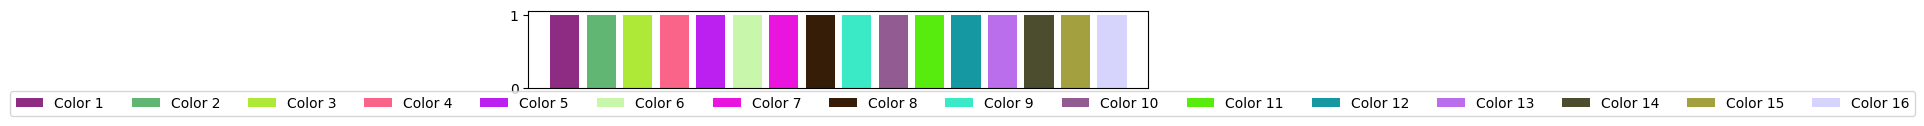

{(21, 152, 162): 8, (53, 29, 8): 8, (58, 234, 199): 8, (76, 76, 47): 8, (88, 235, 14): 8, (97, 182, 115): 8, (142, 43, 130): 8, (146, 92, 147): 8, (162, 160, 63): 1, (175, 233, 55): 6, (186, 110, 235): 8, (188, 32, 240): 8, (200, 246, 171): 8, (214, 212, 253): 8, (233, 21, 222): 4, (249, 100, 136): 8}
    Color                 Count
--  ------------------  -------
 1  RGB(21, 152, 162)         8
 2  RGB(53, 29, 8)            8
 3  RGB(58, 234, 199)         8
 4  RGB(76, 76, 47)           8
 5  RGB(88, 235, 14)          8
 6  RGB(97, 182, 115)         8
 7  RGB(142, 43, 130)         8
 8  RGB(146, 92, 147)         8
 9  RGB(162, 160, 63)         1
10  RGB(175, 233, 55)         6
11  RGB(186, 110, 235)        8
12  RGB(188, 32, 240)         8
13  RGB(200, 246, 171)        8
14  RGB(214, 212, 253)        8
15  RGB(233, 21, 222)         4
16  RGB(249, 100, 136)        8


In [144]:
from tabulate  import tabulate
colors = set()
for i, j in enumerate(sorted_colors):
    colors.add(j[2])
    color_tracker.add_color(j[2])
# print(colors)

# Create a legend with color swatches
legend_labels = ['Color {}'.format(i + 1) for i in range(len(colors))]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))  # Adjust the figsize as needed

# Plot color swatches
for i, color in enumerate(colors):
    ax.bar(i, 1, color=[x / 255 for x in color], label=legend_labels[i])

# Remove the x-axis
ax.set_xticks([])
ax.set_xlim(-1, len(colors))

# Create the legend
ax.legend(loc='center', bbox_to_anchor=(0.7, -0.2), ncol=len(colors))

# Show the legend
plt.show()

colors_and_counts = color_tracker.get_colors()
print(colors_and_counts)

# Convert the colors and counts into a list of lists for tabulate
table_data = [[i+1 ,f"RGB{color}", count] for i, (color, count) in enumerate(colors_and_counts.items())]

# Add headers to the table
headers = ["Color", "Count"]

# Generate and print the table
table = tabulate(table_data, headers)
print(table)

# Reset the color tracker
color_tracker.reset()

In [145]:
# Cosine Simailarity Now

# create a matrix of cosine similarity
cosine_similarity_matrix = np.zeros((len(point_net_emb), len(point_net_emb)))
for i in tqdm(range(len(point_net_emb))):
    for j in range(len(point_net_emb)):
        cosine_similarity_matrix[i][j] = F.cosine_similarity(sorted_tensors[i], sorted_tensors[j], dim=0)


# calculate the cost matrix for hungarian algorithm
cost_matrix = 1 - cosine_similarity_matrix

# apply hungarian algorithm
m = munkres.Munkres()
indexes = m.compute(cost_matrix)

100%|██████████| 115/115 [00:00<00:00, 251.03it/s]


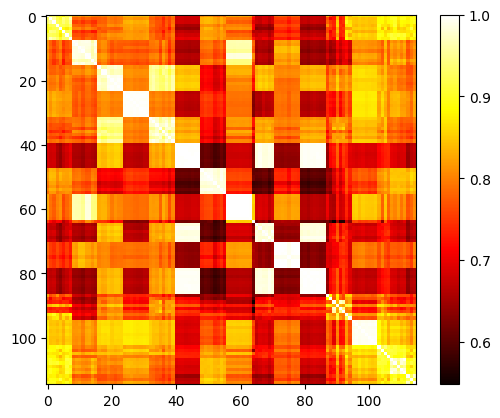

(115, 115)


In [147]:
# plot cosine similarity matrix as heatmap
def heat_map(cosine_mat):
    cosine_mat = np.array(cosine_mat)

    # Plot the heatmap
    plt.imshow(cosine_mat, cmap='hot', interpolation='nearest')

    # Add annotations (values) within each box
    # for i in range(len(cosine_mat)):
    #     for j in range(len(cosine_mat[i])):
    #         plt.text(j, i, f'{cosine_mat[i, j]:.2f}', ha='center', va='center', color='black')

    plt.colorbar()
    plt.show()

heat_map(cosine_similarity_matrix)
print(cosine_similarity_matrix.shape)

In [ ]:
# load pcds from folder
pcds_1 = []
dir = '/scratch/ansh/object pcds 2/'

for file in os.listdir(dir):
    if file.endswith(".pcd"):
        pcds_1.append(o3d.io.read_point_cloud(os.path.join(dir, file)))
    else:
        continue

pcds_2 = []
dir = '/scratch/ansh/object pcds/'

for file in os.listdir(dir):
    if file.endswith(".pcd"):
        pcds_2.append(o3d.io.read_point_cloud(os.path.join(dir, file)))
    else:
        continue

In [ ]:
plot_open3d_pointcloud(pcds_1[15])
plot_open3d_pointcloud(pcds_2[15])

In [ ]:
# Normalize both sets of point clouds using a consistent scaling factor
scaling_factor = max(
    np.max(np.asarray(pcd.points)) - np.min(np.asarray(pcd.points))
    for pcd in pcds_1 + pcds_2  # Combine both sets of point clouds
)

print(scaling_factor)

pcds_1_norm = [np.array(pcd.points) / scaling_factor for pcd in pcds_1]
pcds_2_norm = [np.array(pcd.points) / scaling_factor for pcd in pcds_2]

print(len(pcds_1_norm), len(pcds_2_norm))
zipped_pcds = zip(pcds_1_norm, pcds_2_norm)

print(pcds_1_norm[2].shape)
# Filter pairs with a minimum number of points
# min_num_points = 1024
# filtered_pairs = [
#     pair for pair in zipped_pcds if len(pair[0]) > min_num_points and len(pair[1]) > min_num_points
# ]

# print(filtered_pairs)


34.55681610107422
17 17
(26784, 3)


In [ ]:
# # create a sem_img gif for each view, same view diff orientations
# # Specify the directory path
# dir_path = '/scratch/ansh/Data_Assoc/Dataset/360_multiple'

# # Create a dictionary to store orientation folders, views, and their files
# orientation_views_files = {}

# # Get a list of all items in the directory
# all_items = os.listdir(dir_path)

# # Filter the items to get only folders that start with "orientation"
# orientation_folders = [item for item in all_items if os.path.isdir(os.path.join(dir_path, item)) and item.startswith("orientation")]

# # Loop through the orientation folders
# for item in 